# Overview

This notebook uses the metadata generated in `00_setup.ipynb` to assess summary scenario statistics based on variable coverage.

Our goal is to assess to what degree the scenarios which cover all needed variables for our analysis are representative of the full set of scenario statistics.

Statistical similarity can be assessed through, e.g., [K-S tests](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html)

In [58]:
import pyam
import pathlib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

sns.set_style("whitegrid")

# Read in and prepare data

In [2]:
data_path = pathlib.Path('../data')

In [3]:
fulldf = (
    pd.read_excel(data_path / 'AR6_Scenarios_Database_metadata_indicators_v1.0_variable_coverage.xlsx')
)

In [4]:
hue_order = ['C1', 'C3']
df = fulldf[fulldf['Category'].isin(hue_order)]
df['Full Dataset'] = True

C:\Users\gidden\AppData\Local\Temp\ipykernel_20468\3015732058.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Full Dataset'] = True


In [5]:
df.groupby('Category')[['Full Dataset', 'Global all', 'R5 all', 'R10 all']].count().T

Category,C1,C3
Full Dataset,97,311
Global all,72,232
R5 all,71,232
R10 all,57,174


In [83]:
def make_data(df, keep=[]):
    keep = keep.copy()
    cols = ['Full Dataset', 'Global all', 'R5 all', 'R10 all']
    keep += ['model', 'scenario', 'Category']
    data = df[cols + keep]
    dfs = []
    for col in cols:
        # data where coverage exists
        df = data[~data[col].isnull()].copy()
        df['coverage'] = col
        dfs.append(df)
        # data where coverage does not exist
        df = data[data[col].isnull()].copy()
        df['coverage'] = 'No ' + col
        dfs.append(df)
    return pd.concat(dfs)

In [84]:
variables_of_interest = [
    'CO2 emissions reductions 2019-2030 % modelled Harmonized-Infilled',
    'GHG emissions reductions 2019-2030 % modelled Harmonized-Infilled',
    'Median peak warming (MAGICCv7.5.3)',
    'Median warming in 2100 (MAGICCv7.5.3)',
    'Median year of peak warming (MAGICCv7.5.3)',
    'Cumulative net-negative CO2 (post net-zero, Gt CO2) (Harm-Infilled)',
    'Cumulative net CO2 (2020 to netzero, Gt CO2) (Harm-Infilled)',
    'Cumulative net CO2 (2020-2100, Gt CO2) (Harm-Infilled)',
]

In [85]:
data = make_data(df, keep=variables_of_interest)

# Robustness of results

Data here is not normally distributed (see below). The K-S test can be used to estimate relative representativeness of data subsets. Specifically, with a [p-value of *at least* 0.05](https://www.statology.org/kolmogorov-smirnov-test-python/). We can "reject the hypothesis that the subset comes from a different distribution than the parent". 

In [105]:
def make_robustness_plot(data, variable, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 3))
        
    labels = ['Full Dataset', 'R5 all', 'No R5 all']
    for label in labels:
        sns.kdeplot(
            data=data.query(f"coverage == '{label}'"), 
            x=variable, label=label,
            ax=ax, 
        )
    ax.legend()
    
    if len(variable) > 40:
        s = variable.split(' ')
        label = ' '.join(s[:len(s) // 2]) + '\n' + ' '.join(s[len(s) // 2:])
        ax.set_xlabel(label)
    
    x = data.query("coverage == 'Full Dataset'")[variable]
    y = data.query("coverage == 'R5 all'")[variable]
    result_all = stats.kstest(x, y)
    y = data.query("coverage == 'No R5 all'")[variable]
    result_no = stats.kstest(x, y)
    ax.set_title(
        f'R5 all p={result_all.pvalue:.3f}, p >= 0.05: {result_all.pvalue >= 0.05 }\n'
        f'No R5 all p={result_no.pvalue:.3f}, p >= 0.05: {result_no.pvalue >= 0.05 }\n'
    )
    return ax

In [106]:
len(variables_of_interest)

8

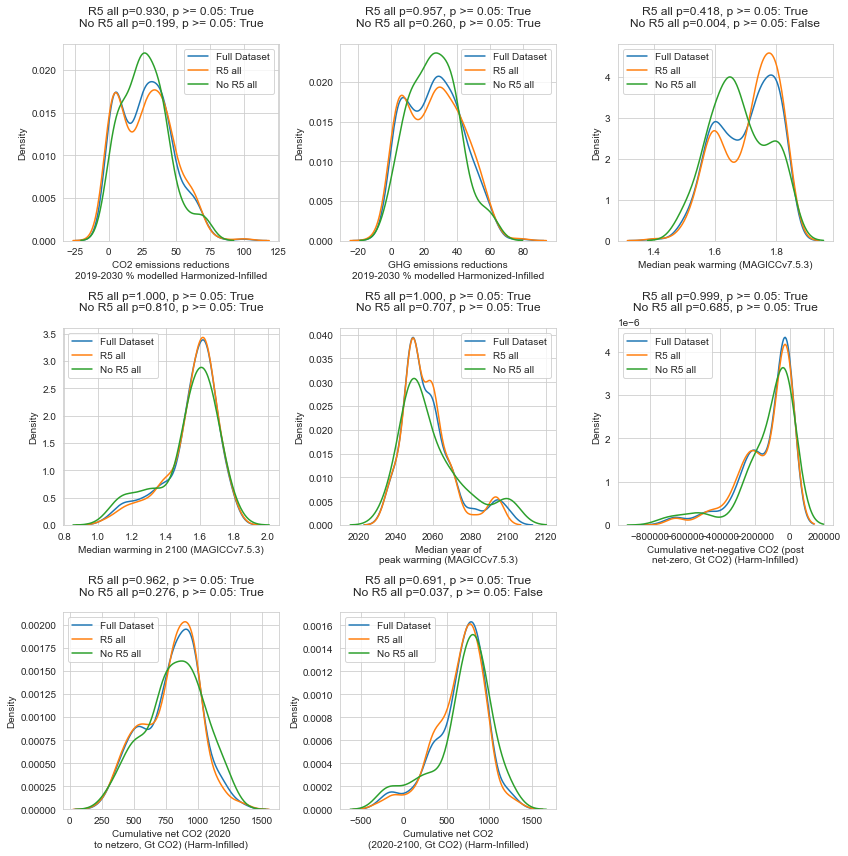

In [107]:
fig, axs = plt.subplots(3, 3, figsize=(3 * 4, 3 * 4))
axs = np.ravel(axs)
for ax, variable in zip(axs, variables_of_interest):
    make_robustness_plot(data, variable=variable, ax=ax)
axs[-1].axis('off')
plt.tight_layout()

In [108]:
variables_of_interest

['CO2 emissions reductions 2019-2030 % modelled Harmonized-Infilled',
 'GHG emissions reductions 2019-2030 % modelled Harmonized-Infilled',
 'Median peak warming (MAGICCv7.5.3)',
 'Median warming in 2100 (MAGICCv7.5.3)',
 'Median year of peak warming (MAGICCv7.5.3)',
 'Cumulative net-negative CO2 (post net-zero, Gt CO2) (Harm-Infilled)',
 'Cumulative net CO2 (2020 to netzero, Gt CO2) (Harm-Infilled)',
 'Cumulative net CO2 (2020-2100, Gt CO2) (Harm-Infilled)']

# Final box plots

In [117]:
def make_box_plots(data, y, axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    coverage = ['Full Dataset', 'Global all', 'R5 all', ]
    
    if len(axs) > 2:
        coverage += ['R10 all']
    sns.boxplot(
        x="Category", y=y, 
        hue="coverage", order=hue_order,
        data=data.query('coverage in @coverage'),
        ax=axs[0]
    )
    
    coverage = ['Full Dataset', 'R5 all', 'No R5 all']
    sns.boxplot(
        x="Category", y=y, 
        hue="coverage", order=hue_order,
        data=data.query('coverage in @coverage'),
        ax=axs[1],
    )
    axs[1].set_ylabel('')
    
    if len(axs) > 2:
        coverage = ['Full Dataset', 'R10 all', 'No R10 all']
        sns.boxplot(
            x="Category", y=y, 
            hue="coverage", order=hue_order,
            data=data.query('coverage in @coverage'),
            ax=axs[2],
        )
        axs[2].set_ylabel('')
    
    return axs

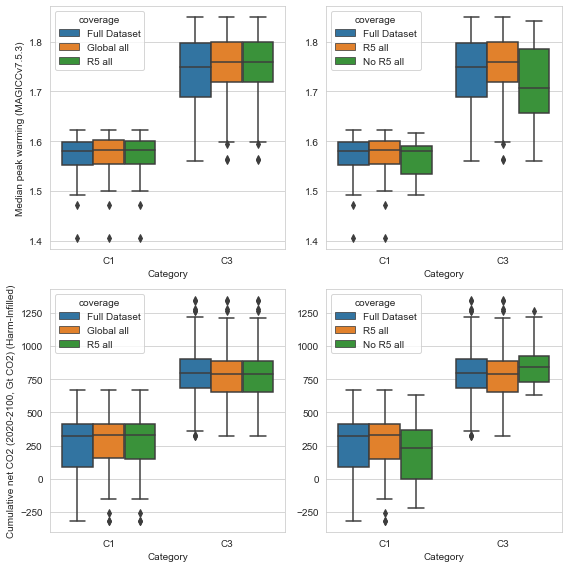

In [118]:
fig, axss = plt.subplots(2, 2, figsize=(2 * 4, 2 * 4))
variables = ['Median peak warming (MAGICCv7.5.3)', 'Cumulative net CO2 (2020-2100, Gt CO2) (Harm-Infilled)']
for axs, variable in zip(axss, variables):
    make_box_plots(data, variable, axs=axs)
plt.tight_layout()